In [ ]:
!pip install pycatch22

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycatch22: filename=pycatch22-0.4.5-cp311-cp311-linux_x86_64.whl size=113659 sha256=e01aeb36097fd7ef369694b34f8eeeb7e74af22b7d8f6e51da9226eda30d3291
  Stored in directory: /root/.cache/pip/wheels/79/9b/3d/e6f1189c5a4a3ff41788a9e37ced0cd0cb0d2af46974aadfbb
Successfully built pycatch22


In [ ]:
!pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 1.6 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [ ]:
# =====================================
# ECG Classifier (HRV features + Catch 22 + RF/SVM/XGBoost)
# Memory Classifier: Five vs Nine vs Thirteen
# Binary Classifier: JustListen vs Memory
# =====================================

import numpy as np
import pickle
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks, resample
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from imblearn.over_sampling import RandomOverSampler
from joblib import dump
from tqdm import tqdm
from scipy.signal import resample
from pycatch22 import catch22_all

warnings.filterwarnings("ignore")
np.random.seed(42)


In [ ]:
# === Load ECG data ===
with open("/content/drive/MyDrive/output_ecg_data/processed_ecg_data.pkl", "rb") as f:
    data_dict = pickle.load(f)

data = data_dict["data"]

# === Utility functions ===
def clean_signals(X):
    X = np.nan_to_num(X)
    return (X - np.mean(X, axis=1, keepdims=True)) / (np.std(X, axis=1, keepdims=True) + 1e-8)

def downsample_signals(X, target_len=2000):
    return np.array([resample(sig, target_len) for sig in X])

def extract_hrv_features(X_signals, sampling_rate=250):  # adjust sampling rate if needed
    from scipy.signal import find_peaks

    def compute_hrv(signal):
        # Detect peaks (R-peaks)
        peaks, _ = find_peaks(signal, distance=sampling_rate * 0.6)  # approx 60 bpm
        rr_intervals = np.diff(peaks) * 1000 / sampling_rate  # convert to ms

        if len(rr_intervals) < 2:
            return [0]*5  # fallback for poor-quality signals

        meanNN = np.mean(rr_intervals)
        SDNN = np.std(rr_intervals)
        RMSSD = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))
        SD1 = np.sqrt(0.5) * RMSSD
        SD2 = np.sqrt(2 * SDNN**2 - 0.5 * RMSSD**2)

        return [meanNN, SDNN, RMSSD, SD1, SD2]

    return np.array([compute_hrv(sig) for sig in tqdm(X_signals, desc="🔍 Extracting HRV")])

def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

def plot_roc_auc(y_true, y_prob, n_classes, title="ROC Curve"):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def train_classifier(X, y, label_names, model, model_name, is_binary=False, feature_names=None):
    print(f"\n⚙️ Training classifier: {model_name}")

    # Fix y labels to be 1D
    y = np.array(y).ravel()

    # Split and handle imbalance
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
    ros = RandomOverSampler(random_state=42)
    X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

    # Cross-Validation
    print("\n🔎 Performing 5-Fold Cross-Validation...")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_res, y_train_res, cv=cv, scoring="accuracy", n_jobs=-1)
    print(f"✅ Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Train model
    start_time = time.time()
    model.fit(X_train_res, y_train_res)
    end_time = time.time()
    print(f"⏱️ Training Time: {end_time - start_time:.2f} seconds")

    # Predictions
    y_pred = model.predict(X_test)
    y_pred = np.array(y_pred).ravel()
    y_proba = model.predict_proba(X_test)

    # Accuracy & Report
    acc = accuracy_score(y_test, y_pred)
    print(f"\n✅ Test Accuracy: {acc:.4f}")
    print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=label_names))

    # Confusion Matrix
    plot_confusion_matrix(y_test, y_pred, labels=label_names, title=f"{model_name} - Confusion Matrix")

    # ROC Curve
    if is_binary:
        positive_class_probs = y_proba[:, 1] if y_proba.shape[1] == 2 else y_proba.ravel()
        roc_auc = roc_auc_score(y_test, positive_class_probs)
        fpr, tpr, _ = roc_curve(y_test, positive_class_probs)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{model_name} - ROC Curve")
        plt.legend()
        plt.show()
    else:
        plot_roc_auc(y_test, y_proba, n_classes=len(label_names), title=f"{model_name} - ROC Curve")

    # Feature Importance
    if isinstance(model, (RandomForestClassifier, XGBClassifier)):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:10]
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(indices)), importances[indices], align="center")

        if feature_names is not None:
            plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45)
        else:
            plt.xticks(range(len(indices)), [f"Feature {i}" for i in indices], rotation=45)

        plt.title(f"{model_name} - Feature Importances")
        plt.show()

    # Save model
    dump(model, f"{model_name}.joblib")
    print(f"✅ Model saved as '{model_name}.joblib'")

📉 Normalizing and downsampling memory signals...
✅ Shape after downsampling - X_mem: (6990, 2000)

🔄 Extracting features for memory classifier...


🔍 Extracting HRV: 100%|██████████| 6990/6990 [00:01<00:00, 5566.62it/s]



⚙️ Training classifier: memory_Random Forest

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.8077 ± 0.0069
⏱️ Training Time: 8.30 seconds

✅ Test Accuracy: 0.8089

✅ Classification Report:
                  precision    recall  f1-score   support

    Five-Memory       0.83      0.93      0.88       599
    Nine-Memory       0.86      0.62      0.72       585
Thirteen-Memory       0.75      0.87      0.81       564

       accuracy                           0.81      1748
      macro avg       0.81      0.81      0.80      1748
   weighted avg       0.82      0.81      0.80      1748



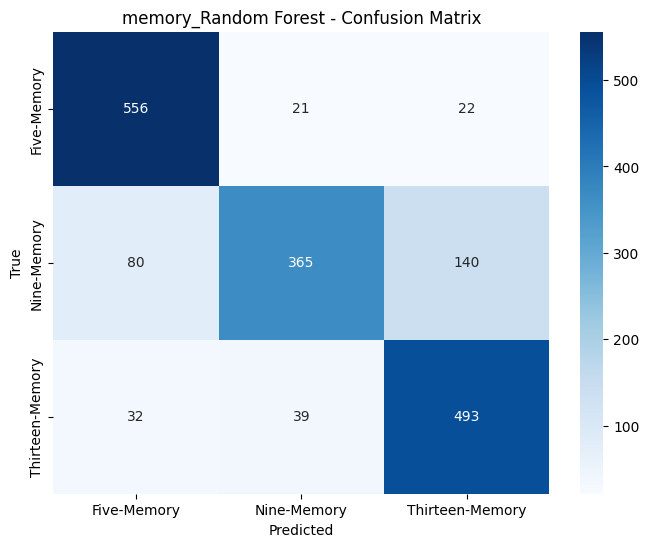

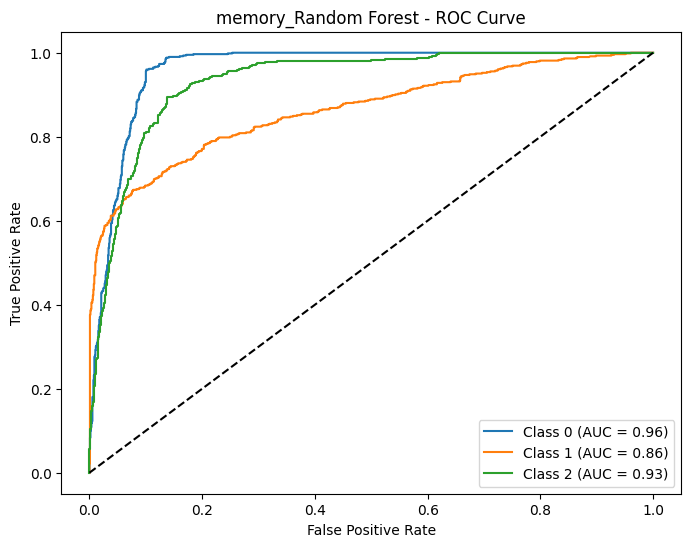

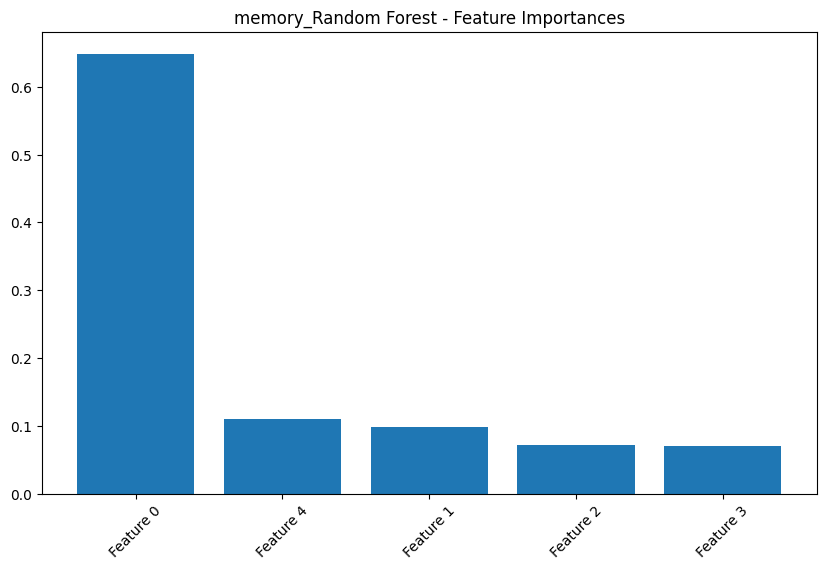

✅ Model saved as 'memory_Random Forest.joblib'

⚙️ Training classifier: memory_SVM

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.6702 ± 0.0077
⏱️ Training Time: 4.63 seconds

✅ Test Accuracy: 0.6876

✅ Classification Report:
                  precision    recall  f1-score   support

    Five-Memory       0.78      0.97      0.87       599
    Nine-Memory       0.59      0.58      0.58       585
Thirteen-Memory       0.66      0.50      0.57       564

       accuracy                           0.69      1748
      macro avg       0.68      0.68      0.67      1748
   weighted avg       0.68      0.69      0.68      1748



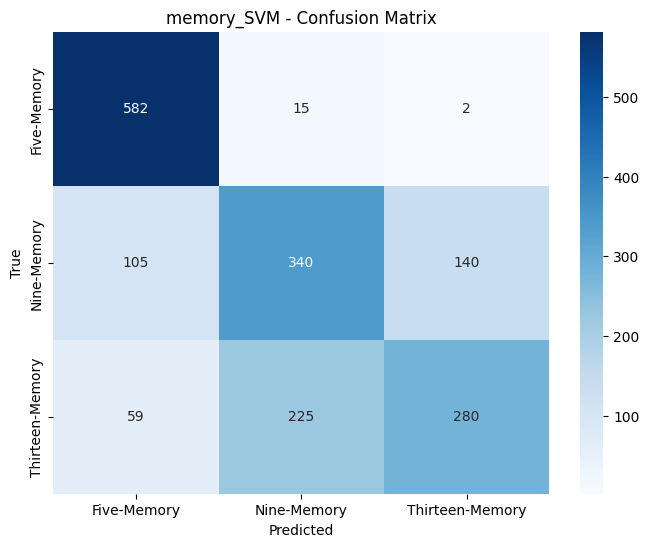

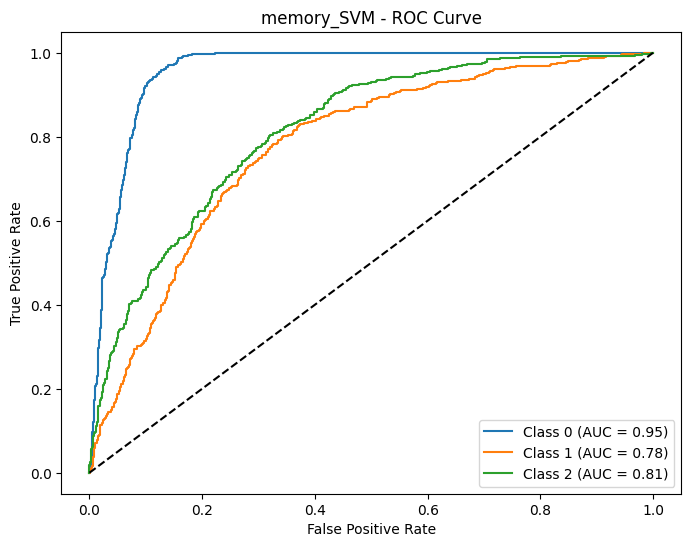

✅ Model saved as 'memory_SVM.joblib'

⚙️ Training classifier: memory_XGBoost

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.7944 ± 0.0066
⏱️ Training Time: 4.01 seconds

✅ Test Accuracy: 0.7912

✅ Classification Report:
                  precision    recall  f1-score   support

    Five-Memory       0.83      0.91      0.87       599
    Nine-Memory       0.77      0.66      0.71       585
Thirteen-Memory       0.76      0.80      0.78       564

       accuracy                           0.79      1748
      macro avg       0.79      0.79      0.79      1748
   weighted avg       0.79      0.79      0.79      1748



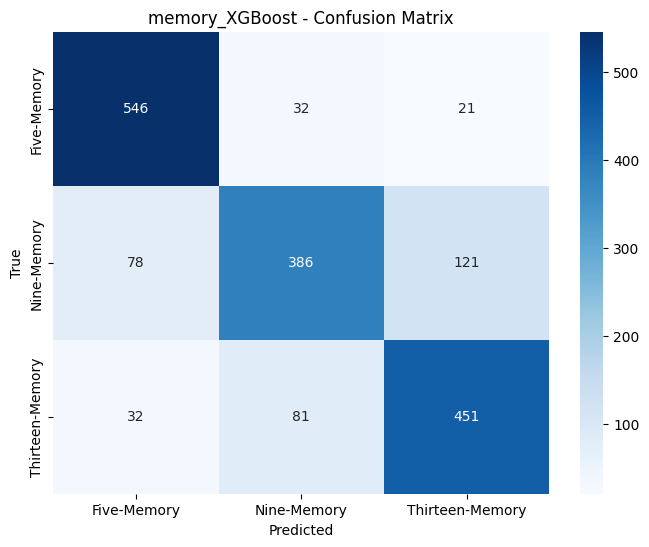

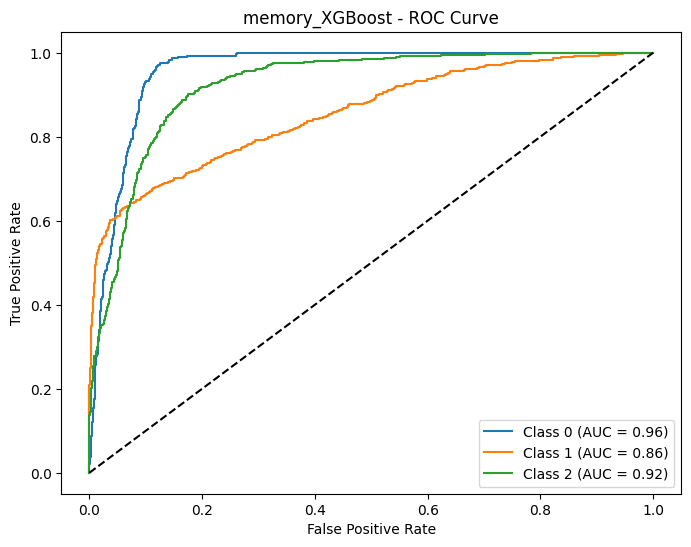

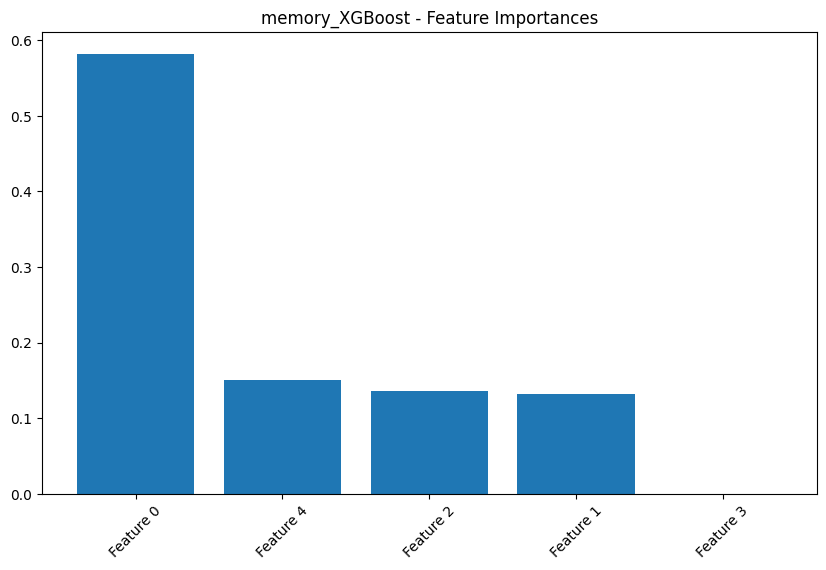

✅ Model saved as 'memory_XGBoost.joblib'


In [ ]:
# === Data Preparation for Memory Classifier ===
X_mem, y_mem = [], []
memory_label_map = {
    "Five-Memory": 0,
    "Nine-Memory": 1,
    "Thirteen-Memory": 2
}

for subj_data in data:
    for cond_idx, condition in enumerate(["Five", "Nine", "Thirteen"]):
        for subcond_idx in [1, 2]:  # Memory Correct, Memory Incorrect
            for trial_idx in range(54):
                signal = subj_data[cond_idx, subcond_idx, trial_idx, :]
                if not np.isnan(signal).all():
                    label = f"{condition}-Memory"
                    X_mem.append(signal)
                    y_mem.append(memory_label_map[label])



X_mem = np.array(X_mem)
print("📉 Normalizing and downsampling memory signals...")
X_mem = clean_signals(X_mem)
X_mem = downsample_signals(X_mem, target_len=2000)
print("✅ Shape after downsampling - X_mem:", X_mem.shape)

print("\n🔄 Extracting features for memory classifier...")
X_mem_features = extract_hrv_features(X_mem)

# === Models ===
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=500, max_depth=10, min_samples_split=5,bootstrap= False, max_features='sqrt', min_samples_leaf=2,
        class_weight="balanced", random_state=42, n_jobs=-1
    ),
    "SVM": SVC(
        kernel="rbf", probability=True, class_weight="balanced", random_state=42
    ),
    "XGBoost": XGBClassifier(
    n_estimators=500, max_depth=10, learning_rate=0.05,
    objective="multi:softprob", num_class=3, random_state=42, n_jobs=-1
    ),

}

# === Training on Memory Classifier ===
for model_name, model in models.items():
    train_classifier(X_mem_features, np.array(y_mem), list(memory_label_map.keys()), model, f"memory_{model_name}", is_binary=False)


📉 Normalizing and downsampling binary signals...
✅ Shape after downsampling - X_jm: (10241, 2000)

🔄 Extracting features for binary classifier...


🔍 Extracting HRV: 100%|██████████| 10241/10241 [00:02<00:00, 4711.14it/s]



⚙️ Training classifier: justlisten_vs_memory_Random Forest

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.6027 ± 0.0149
⏱️ Training Time: 13.02 seconds

✅ Test Accuracy: 0.5033

✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.30      0.44      0.36       813
      Memory       0.67      0.53      0.59      1748

    accuracy                           0.50      2561
   macro avg       0.49      0.49      0.48      2561
weighted avg       0.55      0.50      0.52      2561



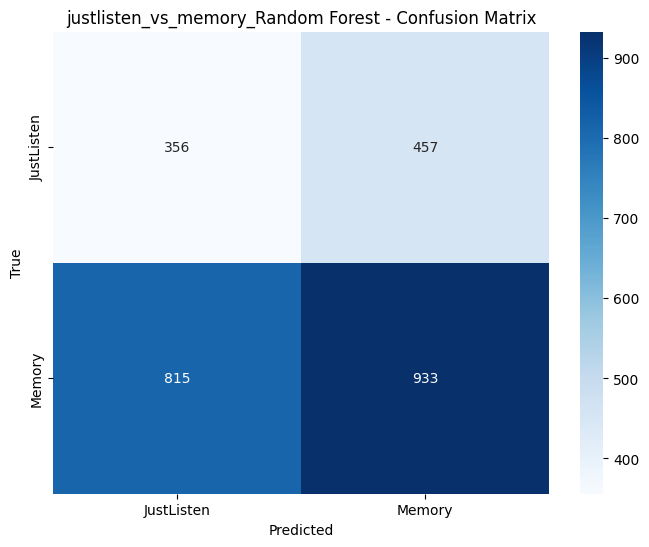

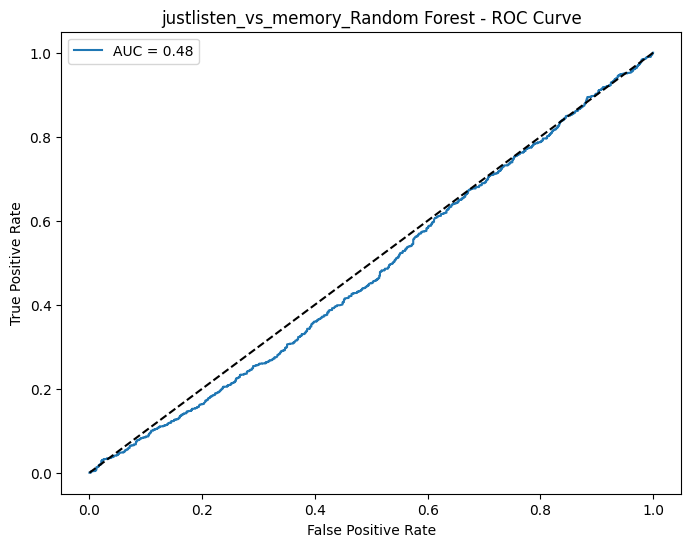

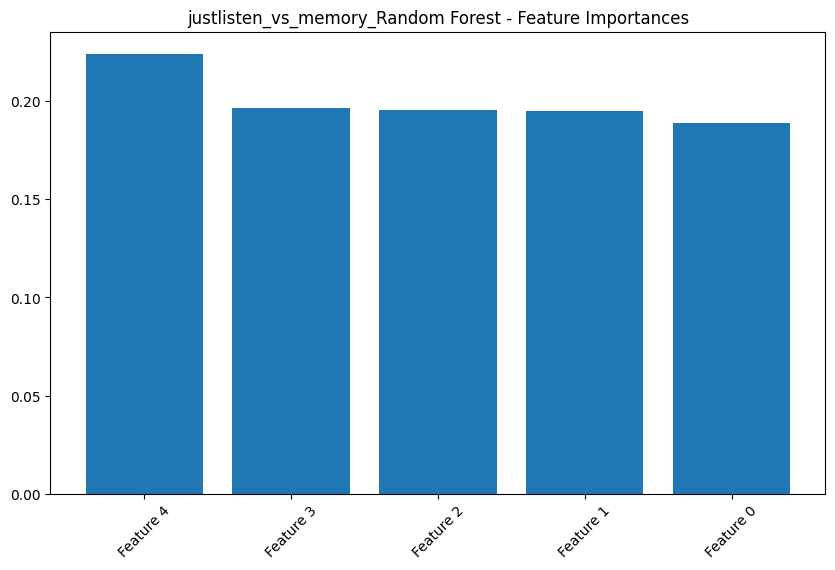

✅ Model saved as 'justlisten_vs_memory_Random Forest.joblib'

⚙️ Training classifier: justlisten_vs_memory_SVM

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.5052 ± 0.0142
⏱️ Training Time: 26.42 seconds

✅ Test Accuracy: 0.5252

✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.31      0.41      0.35       813
      Memory       0.68      0.58      0.62      1748

    accuracy                           0.53      2561
   macro avg       0.49      0.49      0.49      2561
weighted avg       0.56      0.53      0.54      2561



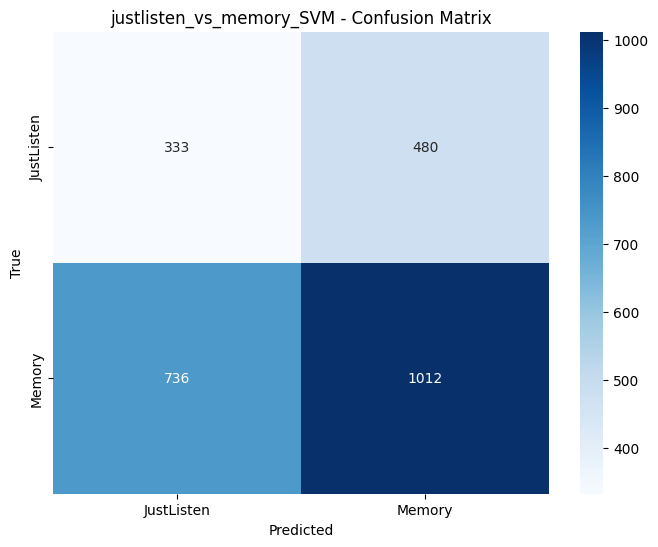

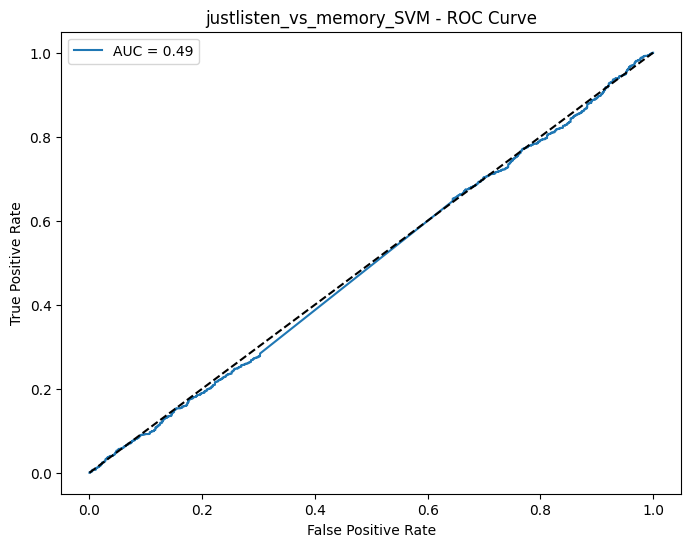

✅ Model saved as 'justlisten_vs_memory_SVM.joblib'

⚙️ Training classifier: justlisten_vs_memory_XGBoost

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.6730 ± 0.0127
⏱️ Training Time: 0.76 seconds

✅ Test Accuracy: 0.5564

✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.32      0.35      0.33       813
      Memory       0.68      0.65      0.67      1748

    accuracy                           0.56      2561
   macro avg       0.50      0.50      0.50      2561
weighted avg       0.57      0.56      0.56      2561



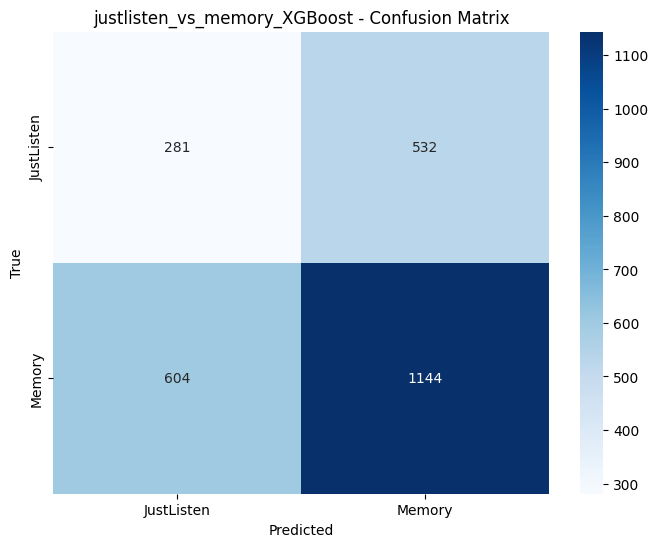

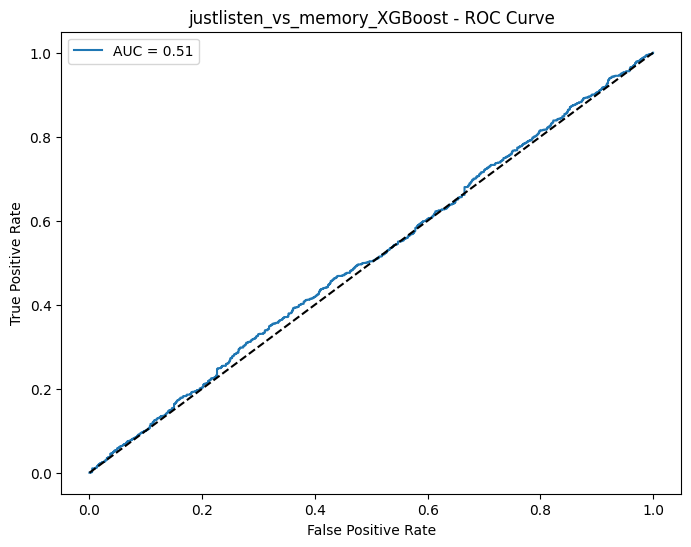

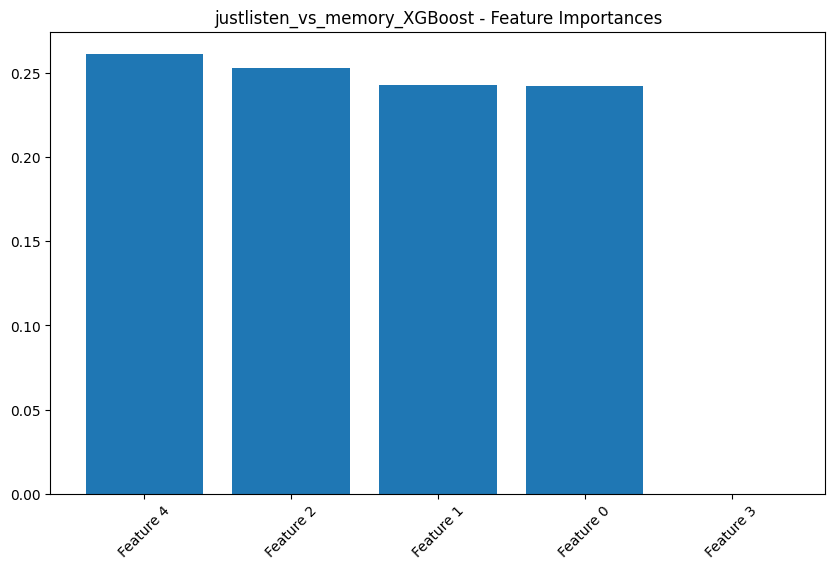

✅ Model saved as 'justlisten_vs_memory_XGBoost.joblib'


In [ ]:
# === Data Preparation for JustListen vs Memory Classifier ===
X_jm, y_jm = [], []
for subj_data in data:
    for cond_idx, condition in enumerate(["Five", "Nine", "Thirteen"]):
        for subcond_idx in range(3):
            for trial_idx in range(54):
                signal = subj_data[cond_idx, subcond_idx, trial_idx, :]
                if not np.isnan(signal).all():
                    label = 0 if subcond_idx == 0 else 1  # JustListen = 0, Memory = 1
                    X_jm.append(signal)
                    y_jm.append(label)

X_jm = np.array(X_jm)
print("\n📉 Normalizing and downsampling binary signals...")
X_jm = clean_signals(X_jm)
X_jm = downsample_signals(X_jm, target_len=2000)
print("✅ Shape after downsampling - X_jm:", X_jm.shape)

print("\n🔄 Extracting features for binary classifier...")
X_jm_features = extract_hrv_features(X_jm)

X_jm_features = np.nan_to_num(X_jm_features, nan=0.0, posinf=0.0, neginf=0.0)

# === Models for JustListen vs Memory Classifier ===
binary_models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=500, max_depth=10, min_samples_split=5,bootstrap= False, max_features='sqrt', min_samples_leaf=2,
        class_weight="balanced", random_state=42, n_jobs=-1
    ),
    "SVM": SVC(
        kernel="rbf", probability=True, class_weight="balanced", random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=500, max_depth=6, learning_rate=0.05,
        objective="binary:logistic", random_state=42, n_jobs=-1
    ),
}

# === Training on Binary Classifier ===
for model_name, model in binary_models.items():
    train_classifier(X_jm_features, np.array(y_jm), ["JustListen", "Memory"], model, f"justlisten_vs_memory_{model_name}", is_binary=True)



📉 Normalizing and downsampling 4-class signals...
✅ Shape after downsampling - X_4c: (10241, 2000)

🔄 Extracting features for 4-class classifier...


🔍 Extracting HRV: 100%|██████████| 10241/10241 [00:01<00:00, 5563.30it/s]



⚙️ Training classifier: fourclass_Random Forest

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.6235 ± 0.0102
⏱️ Training Time: 11.78 seconds

✅ Test Accuracy: 0.5389

✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.32      0.05      0.09       813
        Five       0.57      0.89      0.69       599
        Nine       0.60      0.61      0.60       585
    Thirteen       0.50      0.80      0.62       564

    accuracy                           0.54      2561
   macro avg       0.50      0.59      0.50      2561
weighted avg       0.48      0.54      0.46      2561



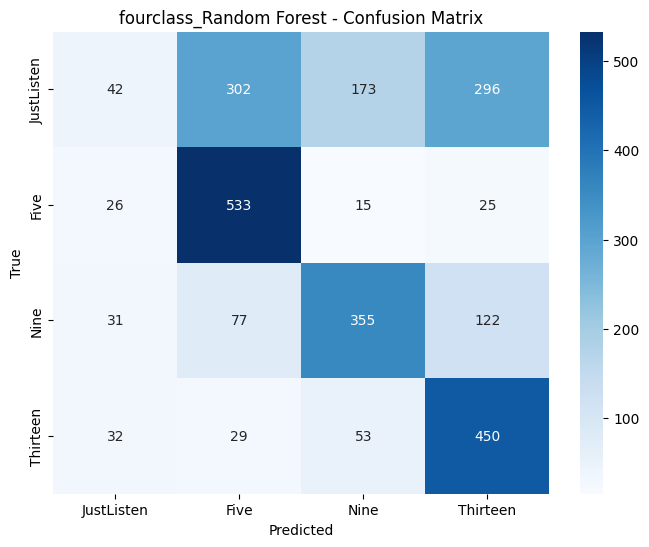

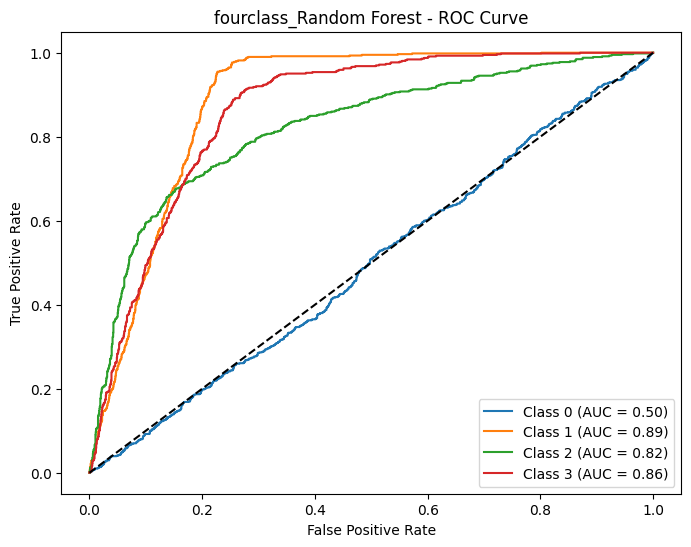

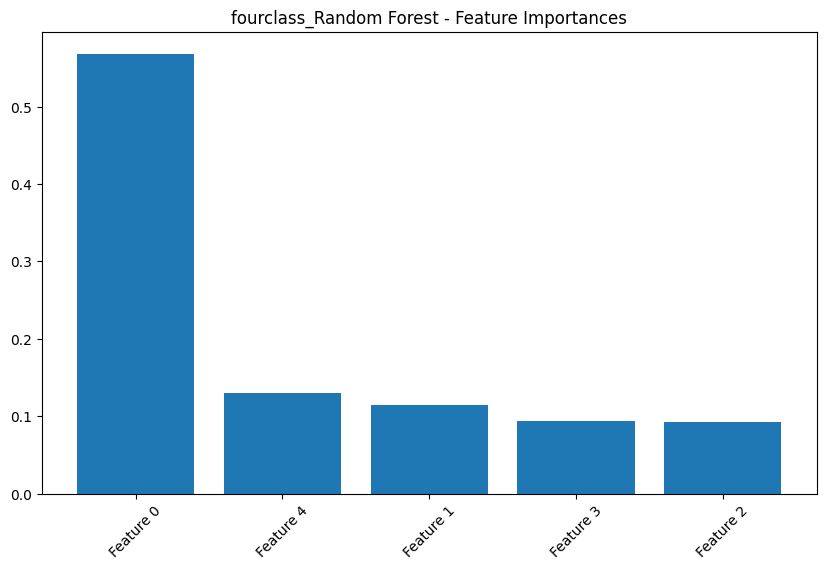

✅ Model saved as 'fourclass_Random Forest.joblib'

⚙️ Training classifier: fourclass_SVM

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.5027 ± 0.0074
⏱️ Training Time: 24.07 seconds

✅ Test Accuracy: 0.4631

✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.27      0.04      0.08       813
        Five       0.53      0.96      0.69       599
        Nine       0.41      0.51      0.46       585
    Thirteen       0.45      0.48      0.46       564

    accuracy                           0.46      2561
   macro avg       0.41      0.50      0.42      2561
weighted avg       0.40      0.46      0.39      2561



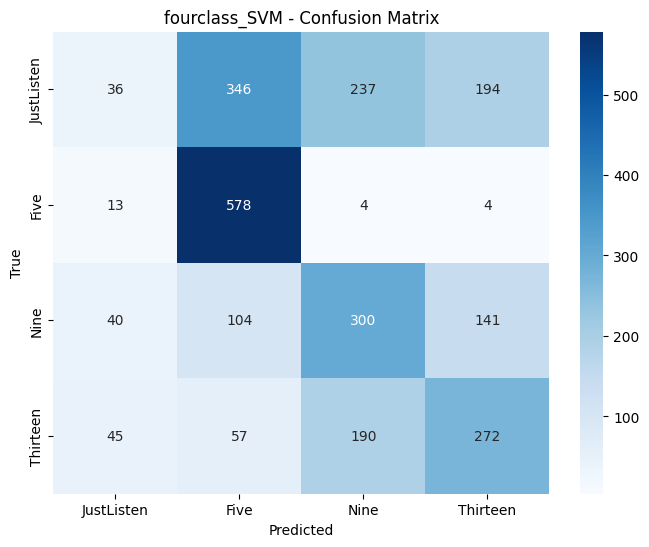

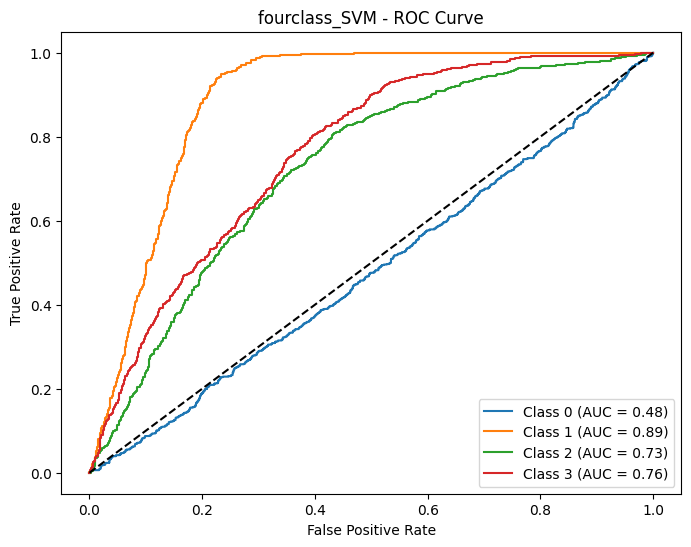

✅ Model saved as 'fourclass_SVM.joblib'

⚙️ Training classifier: fourclass_XGBoost

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.6421 ± 0.0115
⏱️ Training Time: 9.45 seconds

✅ Test Accuracy: 0.4943

✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.32      0.21      0.25       813
        Five       0.56      0.75      0.64       599
        Nine       0.55      0.54      0.54       585
    Thirteen       0.50      0.59      0.54       564

    accuracy                           0.49      2561
   macro avg       0.48      0.52      0.50      2561
weighted avg       0.47      0.49      0.47      2561



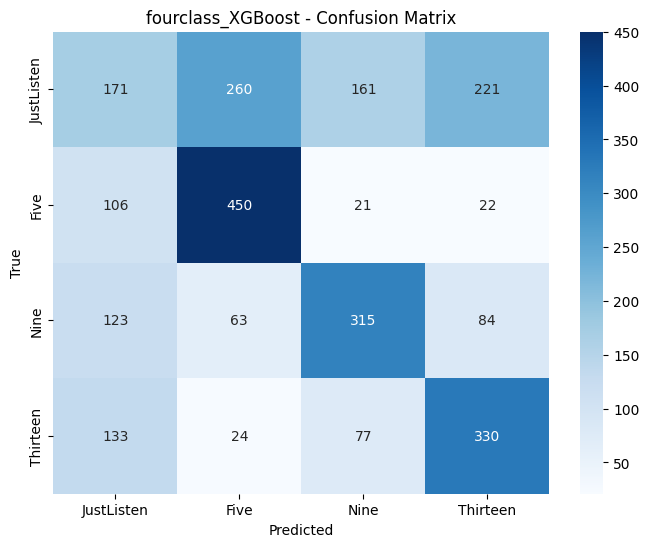

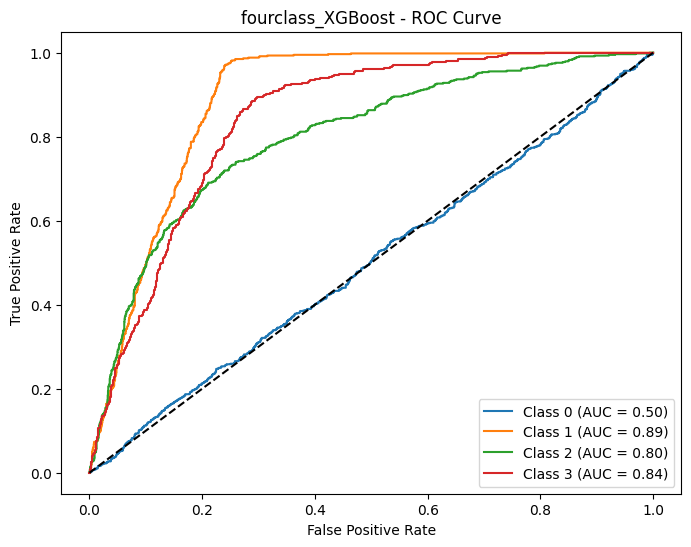

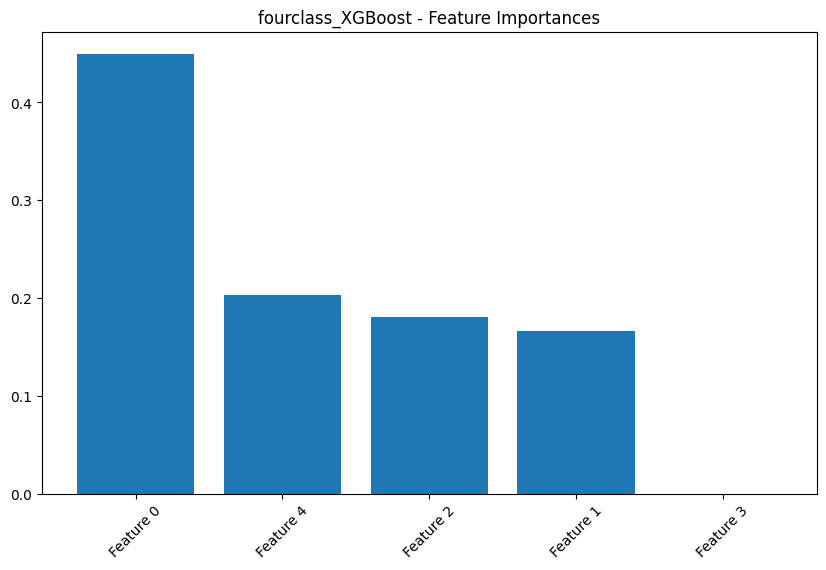

✅ Model saved as 'fourclass_XGBoost.joblib'


In [ ]:
# === Data Preparation for 4-Class Classifier ===

# 4-Class Label Mapping
fourclass_label_map = {
    "JustListen": 0,
    "Five": 1,
    "Nine": 2,
    "Thirteen": 3
}

X_4c, y_4c = [], []
for subj_data in data:
    for cond_idx, condition in enumerate(["Five", "Nine", "Thirteen"]):
        # JustListen
        for trial_idx in range(54):
            signal = subj_data[cond_idx, 0, trial_idx, :]
            if not np.isnan(signal).all():
                X_4c.append(signal)
                y_4c.append(fourclass_label_map["JustListen"])
# Add memory trials similarly with correct label mapping
        # MemoryCorrect + MemoryIncorrect
        for subcond_idx in [1, 2]:
            for trial_idx in range(54):
                signal = subj_data[cond_idx, subcond_idx, trial_idx, :]
                if not np.isnan(signal).all():
                    label = fourclass_label_map[["Five", "Nine", "Thirteen"][cond_idx]]
                    X_4c.append(signal)
                    y_4c.append(label)

X_4c = np.array(X_4c)
print("\n📉 Normalizing and downsampling 4-class signals...")
X_4c = clean_signals(X_4c)
X_4c = downsample_signals(X_4c, target_len=2000)
print("✅ Shape after downsampling - X_4c:", X_4c.shape)

print("\n🔄 Extracting features for 4-class classifier...")
X_4c_features = extract_hrv_features(X_4c)

X_4c_features = np.nan_to_num(X_4c_features, nan=0.0, posinf=0.0, neginf=0.0)

# === Models for 4-Class Classifier ===
fourclass_models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=500, max_depth=10, min_samples_split=5, bootstrap=False, max_features='sqrt', min_samples_leaf=2,
        class_weight="balanced", random_state=42, n_jobs=-1
    ),
    "SVM": SVC(
        kernel="rbf", probability=True, class_weight="balanced", random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=500, max_depth=10, learning_rate=0.05,
        objective="multi:softprob", random_state=42, n_jobs=-1
    ),
}

# === Training on 4-Class Classifier ===
for model_name, model in fourclass_models.items():
    train_classifier(X_4c_features, np.array(y_4c), list(fourclass_label_map.keys()), model, f"fourclass_{model_name}", is_binary=False)
